In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [ ]:
SEED=411

In [2]:
gp = pd.read_csv('aggregated_features.csv')

In [3]:
train = pd.read_csv('train.csv', parse_dates=['activation_date'])
test = pd.read_csv('test.csv', parse_dates=['activation_date'])

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,med_days_up_user,med_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,8.0,2.0,2.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,NaN,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,3.0,1.0,9.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,18.0,3.0,32.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,NaN,NaN,NaN


In [4]:
train = train.sort_values(['activation_date']).reset_index(drop=True)

In [5]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=519)

In [6]:
train.loc[train_index, 'activation_date'].dt.weekday.value_counts()

0    207048
6    205318
1    201131
2    196631
3    191293
4    176527
5    175133
Name: activation_date, dtype: int64

In [7]:
train.loc[valid_index, 'activation_date'].dt.weekday.value_counts()

0    23007
6    22614
1    22289
2    21884
3    21422
4    19599
5    19528
Name: activation_date, dtype: int64

In [8]:
test.loc[:, 'activation_date'].dt.weekday.value_counts()

2    81888
1    81114
0    80191
3    77177
4    70366
6    58909
5    58793
Name: activation_date, dtype: int64

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [9]:
train[agg_cols].isnull().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [10]:
test[agg_cols].isnull().any(axis=1).sum() / len(test) * 100

24.354198545348694

In [11]:
train.isnull().sum(), test.isnull().sum()

(item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  61576
 param_2                 654542
 param_3                 862565
 title                        0
 description             116276
 price                    85362
 item_seq_number              0
 activation_date              0
 user_type                    0
 image                   112588
 image_top_1             112588
 deal_probability             0
 avg_days_up_user        336875
 avg_times_up_user       336875
 med_days_up_user        336875
 med_times_up_user       336875
 n_user_items            336875
 dtype: int64, item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  22910
 param_2                 2

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

## Common Features

In [12]:
import string

In [13]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])


for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
    
    for col in ['price', 'image_top_1']:
         df[col].fillna(-1, inplace=True)
            
    for col in ['param_1', 'param_2', 'param_3']:
         df[col].fillna('khwinkaggle', inplace=True)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]

categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

## User Features

In [16]:
from copy import deepcopy as cp
col = 'user_id'
user_vc = train[col].append(test[col]).value_counts()
old_user_vc = cp(user_vc)
user_vc = user_vc[user_vc>30]
users = user_vc.index
user_filter = users.isin(train[col]) & users.isin(test[col])

print('Original feature types # = {}, new feature types # = {}'.format(
        len(old_user_vc), pd.Series(user_filter).value_counts()[1]))

print(train.loc[train[col].isin(users[user_filter]), col].value_counts().sort_index())
print(test.loc[test[col].isin(users[user_filter]), col].value_counts().sort_index())
print(train.loc[train[col].isin(users[user_filter]), :].shape[0]/train.shape[0]*100.)
print(test.loc[test[col].isin(users[user_filter]), :].shape[0]/test.shape[0]*100.)

Original feature types # = 1009909, new feature types # = 1206
00051c5a5f57     28
00179aa3c386     41
002fb45acb3f     16
004e5c8b2870     19
00a25ff400ad     35
00c5b94b7a0b     25
010f0729f73a     46
0153902752ed     12
017e9b28eda7     24
018ef9eebba0     16
0193cd5b7517     31
01950439a810     36
01adfb9f336f     45
01c73e264ee9     11
01d2db21def6     51
01dd42c9ca6d     40
02019da6857a     27
0201f4ceb3f6     79
03082624a937    396
0333e0767abf     54
03f616357c02     39
047d27fa4473    133
048095052e86     43
0492af69a4d3     28
04d0805871df     39
057526b08f9f     44
0582d1147bd9     17
0601d1e1b0bb     23
0615f14167f0     60
0665f480fd70     79
               ... 
f9cf1dabe1d0     80
fa0d3d9023cb    221
fab381155b7f     67
fbc9ad428501     40
fc0907cb4003     31
fc34d16e5103    130
fc39a0d34c08     55
fc7623fecf00     56
fca7a7a72a65     28
fcab302a2470     12
fcc94ec6517e      6
fcc9aea60220     33
fcda5accf7f5     30
fcdb2e335e4d     31
fcf1a1645f59     42
fd390da435b4     

In [17]:
train.loc[~train[col].isin(users[user_filter]), col] = 'others_users'
test.loc[~test[col].isin(users[user_filter]), col] = 'others_users'

In [18]:
gp = train.groupby('user_id')

In [19]:
for col in ['price', 'item_seq_number', 'num_desc_punct']:
    mean_mapping, std_mapping = gp[col].mean(), gp[col].std()
    
    train.loc[:, col+'_user_mean'] = train['user_id'].map(mean_mapping).fillna(0.)
    test.loc[:, col+'_user_mean'] = test['user_id'].map(mean_mapping).fillna(0.)
    
    train.loc[:, col+'_user_std'] = train['user_id'].map(std_mapping).fillna(0.)
    test.loc[:, col+'_user_std'] = test['user_id'].map(std_mapping).fillna(0.)
    
    predictors.extend([col+'_user_mean', col+'_user_std'])
    print(col+' processed')

price processed
item_seq_number processed
num_desc_punct processed


In [20]:
train.isnull().sum(), '\n', test.isnull().sum()

(item_id                              0
 user_id                              0
 region                               0
 city                                 0
 parent_category_name                 0
 category_name                        0
 param_1                              0
 param_2                              0
 param_3                              0
 title                                0
 description                          0
 price                                0
 item_seq_number                      0
 activation_date                      0
 user_type                            0
 image                           112588
 image_top_1                          0
 deal_probability                     0
 avg_days_up_user                     0
 avg_times_up_user                    0
 med_days_up_user                     0
 med_times_up_user                    0
 n_user_items                         0
 weekday                              0
 num_words_description                0


In [21]:
for col in categorical:
    type_cnt = gp[col].apply(lambda x: len(set(x)))
    train.loc[:, col+'_user_type_cnt'] = train['user_id'].map(type_cnt).fillna(0.)
    test.loc[:, col+'_user_type_cnt'] = test['user_id'].map(type_cnt).fillna(0.)
    predictors.append(col+'_user_type_cnt')
    print(col+' processed')

image_top_1 processed
param_1 processed
param_2 processed
param_3 processed
city processed
region processed
category_name processed
parent_category_name processed
user_type processed


In [22]:
del gp; gc.collect()

529

In [23]:
from sklearn.model_selection import KFold
fold_num = 5
kf = KFold(fold_num, shuffle=True, random_state=SEED)

mean_enc_cols = ['user_id']

for col in mean_enc_cols:    
    
    train.loc[:, col+'_dp_mean_enc'] = np.zeros((train.shape[0],))
    train.loc[:, col+'_dp_std_enc'] = np.zeros((train.shape[0],))
    test.loc[:, col+'_dp_mean_enc'] = np.zeros((test.shape[0],))
    test.loc[:, col+'_dp_std_enc'] = np.zeros((test.shape[0],))
    
    for train_ix, val_ix in kf.split(train):
        tr_X = train.loc[train_ix, :]
    
        gp = tr_X.groupby(col)['deal_probability']
        mapping, mapping_std = gp.mean(), gp.std()
        
        train.loc[val_ix, col+'_dp_mean_enc'] = train.loc[val_ix, col].map(mapping).fillna(0.)
        train.loc[val_ix, col+'_dp_std_enc'] = train.loc[val_ix, col].map(mapping_std).fillna(0.)
        
        test.loc[:, col+'_dp_mean_enc'] += test.loc[:, col].map(mapping).fillna(0.)
        test.loc[:, col+'_dp_std_enc'] += test.loc[:, col].map(mapping_std).fillna(0.)
     
        del gp
        
    test.loc[:, col+'_dp_mean_enc'] /= fold_num
    test.loc[:, col+'_dp_std_enc'] /= fold_num
    print(col + ' processed.')
    predictors.extend([col+'_dp_mean_enc', col+'_dp_std_enc'])

user_id processed.


In [24]:
train.isnull().sum(), '\n', test.isnull().sum()

(item_id                                    0
 user_id                                    0
 region                                     0
 city                                       0
 parent_category_name                       0
 category_name                              0
 param_1                                    0
 param_2                                    0
 param_3                                    0
 title                                      0
 description                                0
 price                                      0
 item_seq_number                            0
 activation_date                            0
 user_type                                  0
 image                                 112588
 image_top_1                                0
 deal_probability                           0
 avg_days_up_user                           0
 avg_times_up_user                          0
 med_days_up_user                           0
 med_times_up_user                

## Text Features

In [25]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

## Encode Categorical Features

In [26]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


## Mean Encoding

In [27]:
for feature in categorical:
    gp = train.groupby(feature)[feature].count()
    train.loc[:, feature+'_cnt'] = train[feature].map(gp)
    test.loc[:, feature+'_cnt'] = test[feature].map(gp)
    predictors.append(feature+'_cnt')

In [28]:
from sklearn.model_selection import KFold
fold_num = 5
kf = KFold(fold_num, shuffle=True, random_state=SEED)

mean_enc_cols = ['item_seq_number']
mean_enc_cols.extend(categorical)

for col in mean_enc_cols:    
    
    train.loc[:, col+'_dp_mean_enc'] = np.zeros((train.shape[0],))
    train.loc[:, col+'_dp_std_enc'] = np.zeros((train.shape[0],))
    test.loc[:, col+'_dp_mean_enc'] = np.zeros((test.shape[0],))
    test.loc[:, col+'_dp_std_enc'] = np.zeros((test.shape[0],))
    
    for train_ix, val_ix in kf.split(train):
        tr_X = train.loc[train_ix, :]
    
        gp = tr_X.groupby(col)['deal_probability']
        mapping, mapping_std = gp.mean(), gp.std()
        
        train.loc[val_ix, col+'_dp_mean_enc'] = train.loc[val_ix, col].map(mapping).fillna(0.)
        train.loc[val_ix, col+'_dp_std_enc'] = train.loc[val_ix, col].map(mapping_std).fillna(0.)
        
        test.loc[:, col+'_dp_mean_enc'] += test.loc[:, col].map(mapping).fillna(0.)
        test.loc[:, col+'_dp_std_enc'] += test.loc[:, col].map(mapping_std).fillna(0.)
     
        del gp
        
    test.loc[:, col+'_dp_mean_enc'] /= fold_num
    test.loc[:, col+'_dp_std_enc'] /= fold_num
    print(col + ' processed.')
    predictors.extend([col+'_dp_mean_enc', col+'_dp_std_enc'])

item_seq_number processed.
image_top_1 processed.
param_1 processed.
param_2 processed.
param_3 processed.
city processed.
region processed.
category_name processed.
parent_category_name processed.
user_type processed.


In [29]:
train.isnull().sum(), '\n', test.isnull().sum()

(item_id                                  0
 user_id                                  0
 region                                   0
 city                                     0
 parent_category_name                     0
 category_name                            0
 param_1                                  0
 param_2                                  0
 param_3                                  0
 title                                    0
 description                              0
 price                                    0
 item_seq_number                          0
 activation_date                          0
 user_type                                0
 image                               112588
 image_top_1                              0
 deal_probability                         0
 avg_days_up_user                         0
 avg_times_up_user                        0
 med_days_up_user                         0
 med_times_up_user                        0
 n_user_items                   

In [30]:
#train.drop(['image_top_1'], axis=1, inplace=True)
#test.drop(['image_top_1'], axis=1, inplace=True)

## Modeling

After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [31]:
rounds = 24000
early_stop_rounds = 200
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 48,
    'max_depth': 15,
    'learning_rate' : 0.02,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31513


In [32]:
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
ml = model_loader('lgb')

In [33]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

In [34]:
x_train = scipy.sparse.hstack([
        train_desc_counts,
        train_title_counts,
        train.loc[:, predictors]
    ], format='csr')
y_train = train.loc[:, target].values

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=SEED)

In [ ]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':5, 
    'learning_rate':0.1, 
    'n_estimators':2000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1., 
    'subsample_freq':1, 
    'colsample_bytree':.6, 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}
fit_param = {
    'feature_name': list(feature_names), 
    'categorical_feature': categorical,
}
fit_param.update({
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
})

try_params = {
    'random_state': [719]
}

fit_params(x_train, y_train, ml, default_params, try_params, fit_params=fit_param, seed=SEED, use_eval_set=True)

## Train OOF Models and Gen Submission

In [37]:
ret = np.zeros((train.shape[0],))
ret_test = np.zeros((x_test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    dtrain = lgb.Dataset(x_train[train_ix,:], label=y_train[train_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    dvalid = lgb.Dataset(x_train[val_ix,:], label=y_train[val_ix],
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(x_train[val_ix,:])
    ret_test += model.predict(x_test)
    ret_models.append(model)
    
    del dtrain, dvalid

E:\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.227318	valid's rmse: 0.228097
[200]	train's rmse: 0.222867	valid's rmse: 0.224661
[300]	train's rmse: 0.220337	valid's rmse: 0.223194
[400]	train's rmse: 0.218559	valid's rmse: 0.222254
[500]	train's rmse: 0.217333	valid's rmse: 0.221703
[600]	train's rmse: 0.216381	valid's rmse: 0.22129
[700]	train's rmse: 0.215614	valid's rmse: 0.221007
[800]	train's rmse: 0.214891	valid's rmse: 0.220751
[900]	train's rmse: 0.214276	valid's rmse: 0.220546
[1000]	train's rmse: 0.21371	valid's rmse: 0.220369
[1100]	train's rmse: 0.213198	valid's rmse: 0.220217
[1200]	train's rmse: 0.212701	valid's rmse: 0.220073
[1300]	train's rmse: 0.212226	valid's rmse: 0.219955
[1400]	train's rmse: 0.211752	valid's rmse: 0.219847
[1500]	train's rmse: 0.211314	valid's rmse: 0.219738
[1600]	train's rmse: 0.21089	valid's rmse: 0.219636
[1700]	train's rmse: 0.210482	valid's rmse: 0.219548
[1800]	train's rmse: 0.210073	valid's rmse: 0.21

[2000]	train's rmse: 0.209161	valid's rmse: 0.220276
[2100]	train's rmse: 0.208823	valid's rmse: 0.220213
[2200]	train's rmse: 0.208486	valid's rmse: 0.220156
[2300]	train's rmse: 0.208146	valid's rmse: 0.220089
[2400]	train's rmse: 0.207834	valid's rmse: 0.220031
[2500]	train's rmse: 0.207517	valid's rmse: 0.21998
[2600]	train's rmse: 0.207194	valid's rmse: 0.21993
[2700]	train's rmse: 0.206874	valid's rmse: 0.219884
[2800]	train's rmse: 0.206569	valid's rmse: 0.219839
[2900]	train's rmse: 0.20627	valid's rmse: 0.219793
[3000]	train's rmse: 0.205969	valid's rmse: 0.219753
[3100]	train's rmse: 0.20568	valid's rmse: 0.219719
[3200]	train's rmse: 0.205397	valid's rmse: 0.21968
[3300]	train's rmse: 0.205124	valid's rmse: 0.219655
[3400]	train's rmse: 0.204855	valid's rmse: 0.219624
[3500]	train's rmse: 0.204572	valid's rmse: 0.21958
[3600]	train's rmse: 0.204297	valid's rmse: 0.219551
[3700]	train's rmse: 0.204041	valid's rmse: 0.219527
[3800]	train's rmse: 0.203792	valid's rmse: 0.219499

[3600]	train's rmse: 0.204509	valid's rmse: 0.218126
[3700]	train's rmse: 0.204245	valid's rmse: 0.218097
[3800]	train's rmse: 0.203982	valid's rmse: 0.21806
[3900]	train's rmse: 0.203722	valid's rmse: 0.218036
[4000]	train's rmse: 0.203465	valid's rmse: 0.218009
[4100]	train's rmse: 0.203221	valid's rmse: 0.217981
[4200]	train's rmse: 0.202971	valid's rmse: 0.217959
[4300]	train's rmse: 0.202717	valid's rmse: 0.21793
[4400]	train's rmse: 0.202467	valid's rmse: 0.217903
[4500]	train's rmse: 0.202232	valid's rmse: 0.217881
[4600]	train's rmse: 0.202006	valid's rmse: 0.217862
[4700]	train's rmse: 0.201754	valid's rmse: 0.217849
[4800]	train's rmse: 0.201531	valid's rmse: 0.217834
[4900]	train's rmse: 0.201309	valid's rmse: 0.217821
[5000]	train's rmse: 0.201065	valid's rmse: 0.217795
[5100]	train's rmse: 0.200825	valid's rmse: 0.217772
[5200]	train's rmse: 0.200602	valid's rmse: 0.217762
[5300]	train's rmse: 0.200385	valid's rmse: 0.217741
[5400]	train's rmse: 0.200167	valid's rmse: 0.21

[4600]	train's rmse: 0.20199	valid's rmse: 0.21814
[4700]	train's rmse: 0.201744	valid's rmse: 0.218113
[4800]	train's rmse: 0.201498	valid's rmse: 0.218083
[4900]	train's rmse: 0.201268	valid's rmse: 0.21806
[5000]	train's rmse: 0.201024	valid's rmse: 0.218038
[5100]	train's rmse: 0.200809	valid's rmse: 0.218025
[5200]	train's rmse: 0.200567	valid's rmse: 0.218003
[5300]	train's rmse: 0.200339	valid's rmse: 0.217986
[5400]	train's rmse: 0.200125	valid's rmse: 0.21797
[5500]	train's rmse: 0.199898	valid's rmse: 0.217954
[5600]	train's rmse: 0.199682	valid's rmse: 0.217941
[5700]	train's rmse: 0.199468	valid's rmse: 0.217923
[5800]	train's rmse: 0.199253	valid's rmse: 0.21791
[5900]	train's rmse: 0.199037	valid's rmse: 0.217893
[6000]	train's rmse: 0.198813	valid's rmse: 0.217875
[6100]	train's rmse: 0.198599	valid's rmse: 0.217862
[6200]	train's rmse: 0.198387	valid's rmse: 0.217854
[6300]	train's rmse: 0.198172	valid's rmse: 0.217839
[6400]	train's rmse: 0.197973	valid's rmse: 0.21783

[6800]	train's rmse: 0.197069	valid's rmse: 0.218462
[6900]	train's rmse: 0.196857	valid's rmse: 0.218452
[7000]	train's rmse: 0.196652	valid's rmse: 0.218436
[7100]	train's rmse: 0.196466	valid's rmse: 0.218427
[7200]	train's rmse: 0.19627	valid's rmse: 0.218421
[7300]	train's rmse: 0.196062	valid's rmse: 0.218403
[7400]	train's rmse: 0.195854	valid's rmse: 0.218391
[7500]	train's rmse: 0.195656	valid's rmse: 0.218383
[7600]	train's rmse: 0.195464	valid's rmse: 0.21837
[7700]	train's rmse: 0.195268	valid's rmse: 0.218364
[7800]	train's rmse: 0.195082	valid's rmse: 0.218359
[7900]	train's rmse: 0.194902	valid's rmse: 0.218353
[8000]	train's rmse: 0.194706	valid's rmse: 0.218341
[8100]	train's rmse: 0.194512	valid's rmse: 0.21833
[8200]	train's rmse: 0.194328	valid's rmse: 0.218327
[8300]	train's rmse: 0.194128	valid's rmse: 0.218318
[8400]	train's rmse: 0.193945	valid's rmse: 0.218309
[8500]	train's rmse: 0.193757	valid's rmse: 0.218301
[8600]	train's rmse: 0.193576	valid's rmse: 0.218

In [38]:
ret_test = ret_test / 5.

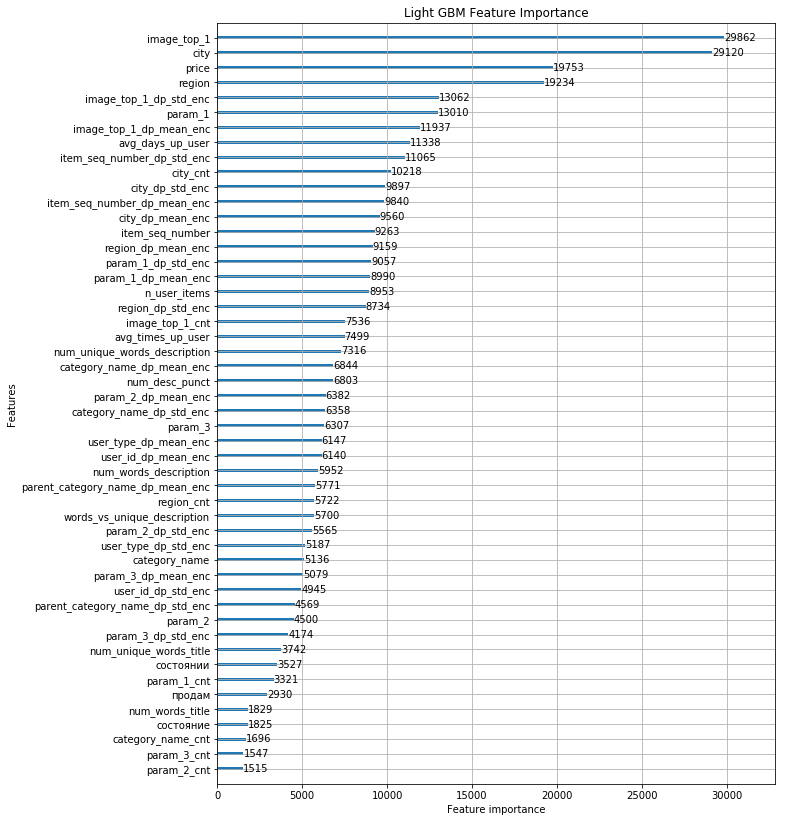

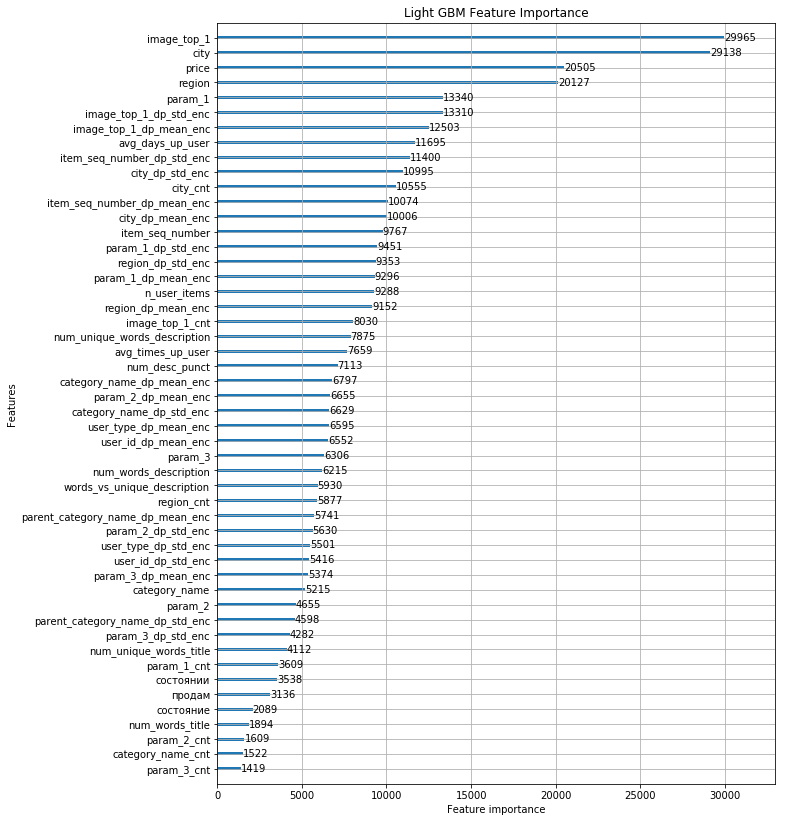

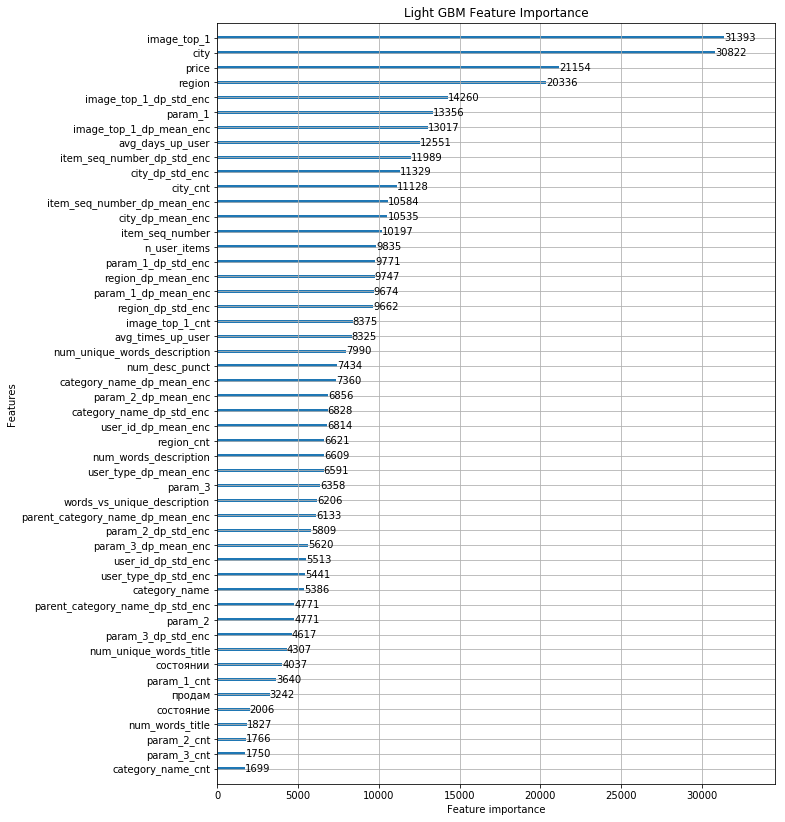

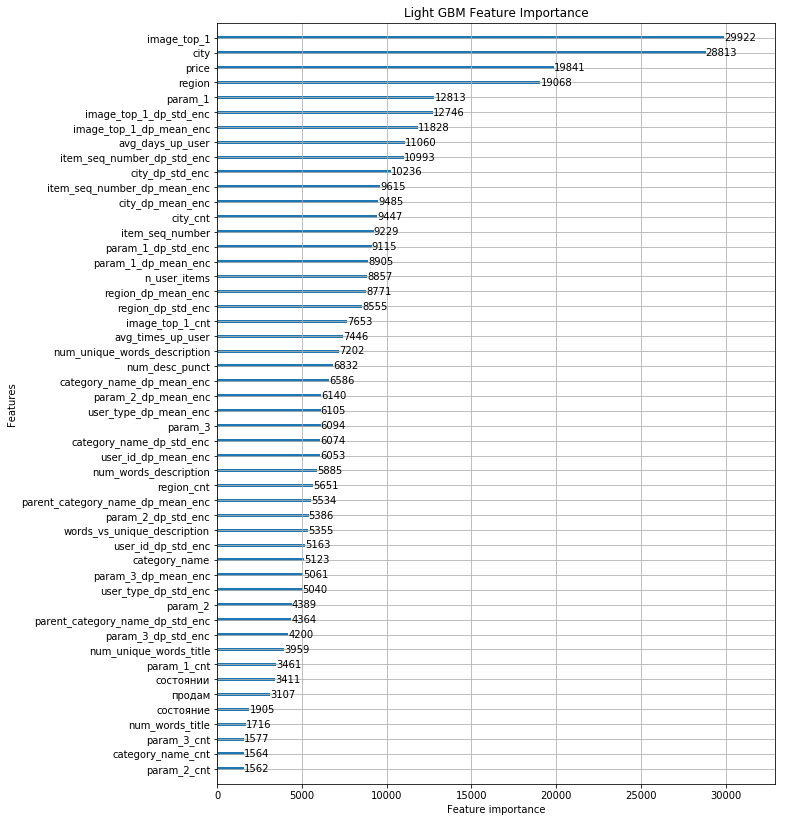

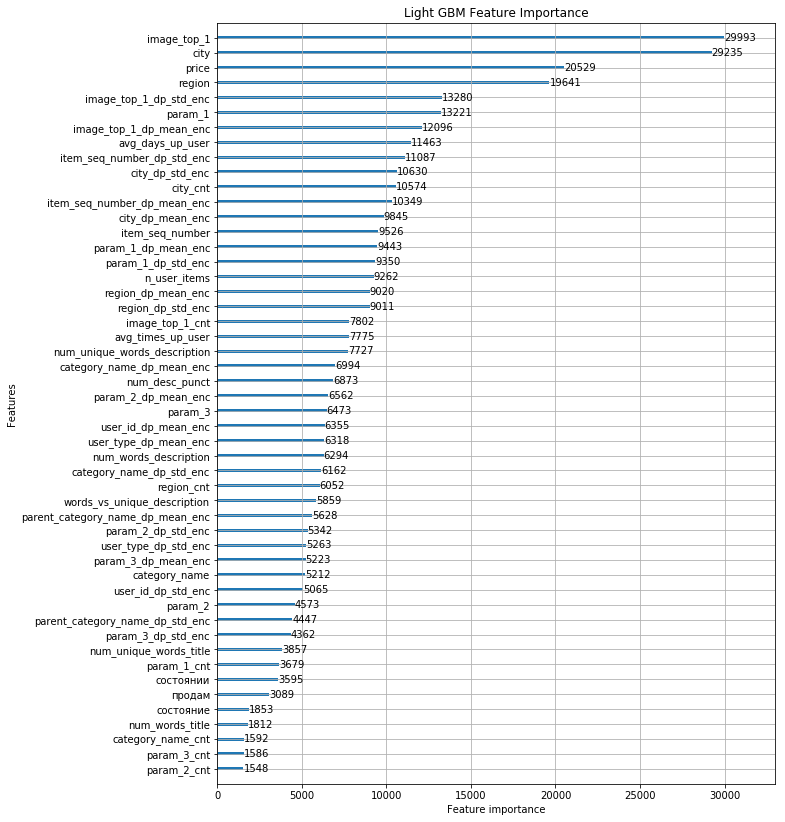

In [39]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [40]:
pd.DataFrame(data=ret, columns=['all_mean_enc_user_feat_lgb_pred']).to_csv('all_mean_enc_user_feat_lgb_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['all_mean_enc_user_feat_lgb_pred']).to_csv('all_mean_enc_user_feat_lgb_oof_test_pred.csv', index=False)

In [41]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('all_mean_enc_user_feat_submission.csv', index=False)

In [42]:
import pickle
for md in ret_models:
    with open('models/all_mean_user_feat_enc_lgb.model', 'wb') as handle:
        pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
ret_test

array([ 0.29667811,  0.13892094,  0.20725971, ...,  0.0500435 ,
        0.29774552,  0.06629708])

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!